In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../../../')
from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import wandb
import random
import tifffile as tiff
import glob

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [3]:
path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/"

In [62]:
patch_size = 64
train_images = tiff.imread(path+"train_data.tif")
train_y = tiff.imread(path+"train_label.tif")
val_images = tiff.imread(path+"val_data.tif")
val_y = tiff.imread(path+"val_label.tif")
test_images = tiff.imread(path+"test_data.tif")
test_y = tiff.imread(path+"test_label.tif")

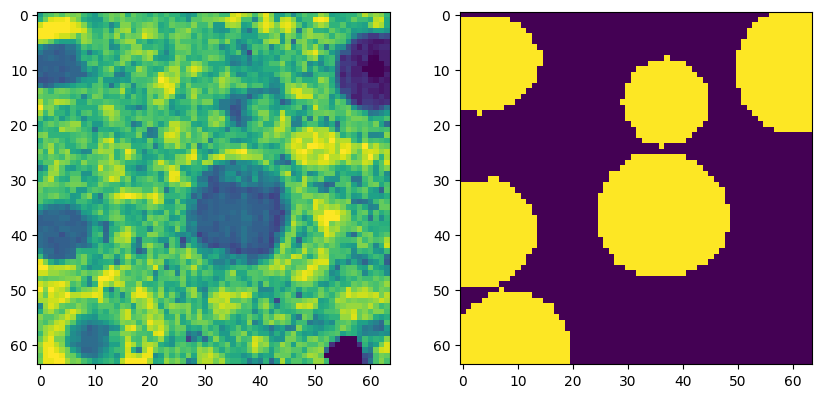

In [5]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(train_images[10000])
plt.subplot(1, 2, 2)
plt.imshow(train_y[10000])
plt.show()

In [68]:
xlist = []
print(len(train_y))
for batch_idx in range(len(train_y)):
        xlist.append(int(train_y[batch_idx][31][31]))
print(set(xlist))

65145
{0, 1, 2, 3}


In [69]:
import torch

In [70]:
a = torch.tensor([0])

In [71]:
b = torch.tensor([0])

In [72]:
a == b

tensor([True])

In [4]:
model_name = "Contrastive_MAE"
directory_path = "./Trained_model/" 

# Data-specific
gaussian_noise_std = None
noiseModel = None 
# Training-specific
batch_size=128
virtual_batch = 64
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=100

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
blocks_per_layer = 5
mask_size = 4
batchnorm = True
free_bits = 0.0 # if KLD is less than 1 then the loss won't be calculated
contrastive_learning = True

In [7]:
debug             = False #[True, False]
save_output       = True #[True, False]
project           = 'Contrastive_MAE'
img_shape = (64,64)

In [8]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,train_y,val_images,val_y,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape,contrastive_learning=contrastive_learning,mask_size=mask_size).cuda()

model.train() # Model set in training mode

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0-3): 4 x TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), 

In [9]:
training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sheida-rk (juglab). Use `wandb login --relogin` to force relogin


Epoch[1/500] Training Loss: 1.268 Reconstruction Loss: 0.659 KL Loss: 0.475 CL Loss: 0.134
saving ./Trained_model/model/Contrastive_MAE_last_vae.net
saving ./Trained_model/model/Contrastive_MAE_best_vae.net
Patience: 0 Validation Loss: 1.0532456636428833 Min validation loss: 1.0532456636428833
Time for epoch: 184seconds
Est remaining time: 1 day, 1:30:16 or 91816 seconds
----------------------------------------
Epoch[2/500] Training Loss: 1.075 Reconstruction Loss: 0.611 KL Loss: 0.412 CL Loss: 0.052
saving ./Trained_model/model/Contrastive_MAE_last_vae.net
saving ./Trained_model/model/Contrastive_MAE_best_vae.net
Patience: 0 Validation Loss: 0.9803071022033691 Min validation loss: 0.9803071022033691
Time for epoch: 182seconds
Est remaining time: 1 day, 1:10:36 or 90636 seconds
----------------------------------------
Epoch[3/500] Training Loss: 1.150 Reconstruction Loss: 0.724 KL Loss: 0.393 CL Loss: 0.033
saving ./Trained_model/model/Contrastive_MAE_last_vae.net
saving ./Trained_mode

KeyboardInterrupt: 

In [5]:
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
clHist=np.load(directory_path+"model/train_cl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

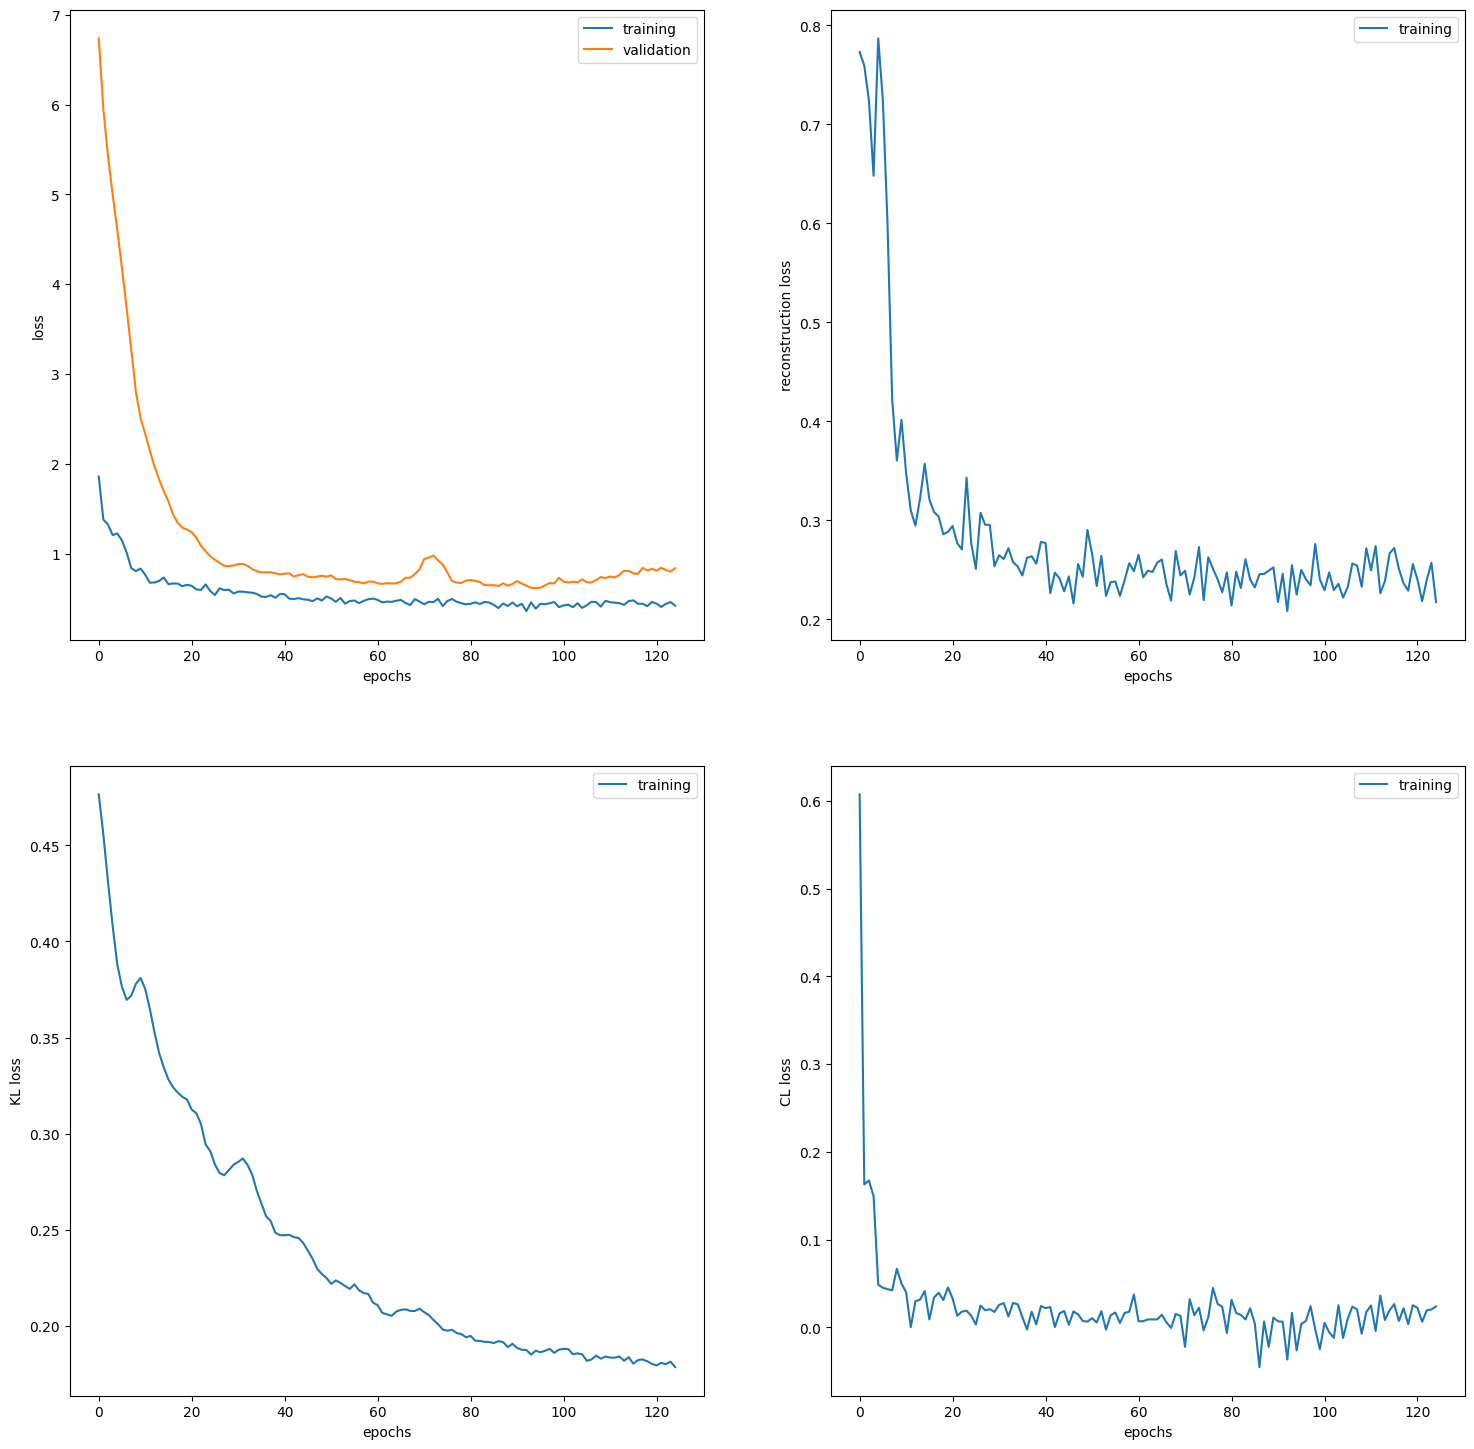

In [6]:
plt.figure(figsize=(18, 18))
plt.subplot(2,2,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()

plt.subplot(2,2,4)
plt.plot(clHist,label='training')
plt.xlabel("epochs")
plt.ylabel("CL loss")
plt.legend()
plt.show()